<a href="https://colab.research.google.com/github/xSakix/AI_colab_notebooks/blob/master/imdb_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB DNN

Simple DNN neted no significant result, so lets try the proper LSTM one.

In [ ]:
import keras
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import re
import os


torch.manual_seed(2019)
np.random.seed(42)
EPS = torch.finfo(torch.float32).eps

max_features = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 


In [ ]:
def convert_to_array(x):
    x_temp = []

    for x in x_train:
        if len(x) < maxlen:
            for i in range(maxlen - len(x)):
                x.append(0.0)
        elif len(x) > maxlen:
            x = x[0:maxlen]

        x_temp.append(x)

    return np.array(x_temp)


(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=max_features)
x_train = convert_to_array(x_train)
x_val = convert_to_array(x_val)
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)

# x_train = x_train.reshape(x_train.shape[0], -1).T
# x_val = x_val.reshape(x_val.shape[0], -1).T

print("*" * 80)
print("x_train:{}".format(x_train.shape))
print("x_val:{}".format(x_val.shape))
print("y_train:{}".format(y_train.shape))
print("y_val:{}".format(y_val.shape))
print("*" * 80)

assert (x_train.shape == (25000,maxlen))
assert (y_train.shape == (25000,1))
assert (x_val.shape == (25000,maxlen))
assert (y_val.shape == (25000,1))

print("*" * 80)

print("max x_train before:{}".format(np.max(x_train)))
print("max x_val before:{}".format(np.max(x_val)))
print("min before:{}, {}".format(np.min(x_train), np.min(x_val)))

# norm didn't work well
# norm = np.linalg.norm(x_train, ord=2)
# print("norm={}".format(norm))

# normalizing around max_features works well
# x_train = x_train / max_features
# x_val = x_val / max_features

# centering around mean
# x_mean = np.mean(x_train)
# x_std = np.std(x_train)
# print("(mean,std)=({},{})".format(x_mean, x_std))
# x_train = (x_train - x_mean) / x_std
# x_val = (x_val - x_mean) / x_std

print("max x_train after norm:{}".format(np.max(x_train)))
print("max x_val after norm:{}".format(np.max(x_val)))
print("min after norm:{}, {}".format(np.min(x_train), np.min(x_val)))

# assert ((x_train >= 0.).all() and (x_train < 1.).all())

print("*" * 80)

print("y_train unique vals:{}".format(np.unique(y_train)))
print("y_val unique vals:{}".format(np.unique(y_train)))

print("*" * 80)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

********************************************************************************
x_train:(25000, 200)
x_val:(25000, 200)
y_train:(25000, 1)
y_val:(25000, 1)
********************************************************************************
********************************************************************************
max x_train before:19999.0
max x_val before:19999.0
min before:0.0, 0.0
max x_train after norm:19999.0
max x_val after norm:19999.0
min after norm:0.0, 0.0
********************************************************************************
y_train unique vals:[0 1]
y_val unique vals:[0 1]
********************************************************************************


In [ ]:
class MyNet(torch.nn.Module):

  def __init__(self, num_tokens, vocab_size, emb_size, hidden_size,batch_size=256):
    super(MyNet,self).__init__()
    self.hidden_size= hidden_size
    self.batch_size = batch_size
    self.emb = torch.nn.Embedding(vocab_size,emb_size)
    # print("num_tokens*emb_size={}".format(num_tokens*emb_size))
    self.lstm = torch.nn.LSTM(emb_size,hidden_size,batch_first=True,bidirectional=True)
    self.out = torch.nn.Linear(hidden_size,1)
    self.drop = torch.nn.Dropout(0.1)

  def forward(self,x):
    hidden = (torch.zeros(2, x.shape[0], self.hidden_size).cuda(),
                torch.zeros(2, x.shape[0], self.hidden_size).cuda())
    # print("x:{}".format(x.size()))
    e = self.emb(x)
    # print("e:{}".format(e.size()))
    # print("f:{}".format(f.size()))
    out, hidden = self.lstm(e)
    # print(out.shape)
    # print(hidden[0].shape)
    # z1 =  torch.cat([hidden[0][-2,:,:], hidden[0][-1,:,:]])
    z1 = hidden[0][-2,:,:]
    # print(self.out.weight.shape)
    # print("z1:{}".format(z1.size()))
    a1 = torch.nn.functional.relu(z1)
    # print("a1:{}".format(a1.size()))
    z2 = self.out(a1)
    # print("z2:{}".format(z2.size()))
    a2 = torch.sigmoid(z2)
    # print("a2:{}".format(a2.size()))
    return a2


In [ ]:
def acc(y_hat,y):
  p = torch.round(y_hat).cuda()
  return torch.sum((p == y)/y.shape[0]).cuda()

In [ ]:
#in torch the num samples is first
x_train = torch.tensor(x_train,dtype=torch.long).cuda()
x_val = torch.tensor(x_val,dtype=torch.long).cuda()
y_train = torch.tensor(y_train,dtype=torch.float32).cuda()
y_val = torch.tensor(y_val,dtype=torch.float32).cuda()

mynet = MyNet(num_tokens=x_train.shape[1],vocab_size=max_features, emb_size=300, hidden_size=32).cuda()

optimizer = torch.optim.Adam(mynet.parameters(), lr = 0.01)
loss_func = torch.nn.BCEWithLogitsLoss().cuda()

batch_size = 16

batches = np.array(list(range(0,x_train.shape[0],batch_size)))
n_b = len(batches)
costs = []
m_accs = []
m_val_accs=[]
for i in range(0, 100):
  np.random.shuffle(batches)
  epoch_loss = 0.
  e_loss = 0.
  accs = 0.
  for idx in batches: 
    x_batch = x_train[idx:idx+batch_size,:]
    y_batch = y_train[idx:idx+batch_size,:]
    out = mynet(x_batch)
    accs += acc(out,y_batch)
    loss = loss_func(out, y_batch)
    e_loss+=loss
    epoch_loss+=loss.item()
  
  mynet.zero_grad()
  e_loss.backward()
  optimizer.step()

  if i % 10 == 0:
    val_accs = 0.
    with torch.no_grad():
      for idx in batches: 
        x_batch = x_val[idx:idx+batch_size,:]
        y_batch = y_val[idx:idx+batch_size,:]
        out = mynet(x_batch)
        val_accs += acc(out,y_batch)
    costs.append(epoch_loss/n_b)
    m_accs.append(accs/n_b)
    m_val_accs.append(val_accs/n_b)
    print("{}, {}, {}".format(epoch_loss/n_b, accs/n_b,val_accs/n_b))



0.722249915717278, 0.4988803565502167, 0.49936020374298096
0.6865228753172276, 0.5003598928451538, 0.5000399947166443
0.6691962859604653, 0.5510236620903015, 0.49776071310043335
0.6453317878952564, 0.6524312496185303, 0.49972009658813477
0.6238542690310658, 0.6975767612457275, 0.5
0.6114899714406453, 0.7060540914535522, 0.5001999139785767
0.5917995866871918, 0.7084932923316956, 0.5005598068237305
0.5546361616766765, 0.9376199841499329, 0.49664106965065
0.5362062855401408, 0.9511756300926208, 0.49772071838378906
0.5287523491788353, 0.9599727988243103, 0.49744081497192383


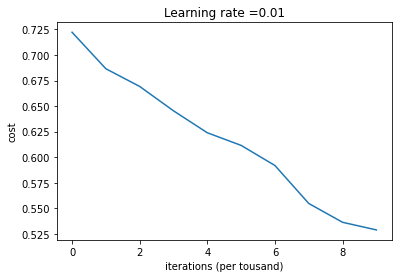

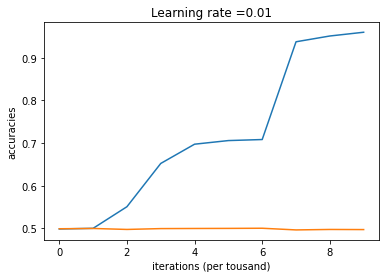

In [ ]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per tousand)')
plt.title("Learning rate =" + str(0.01))
plt.show()

plt.plot(m_accs)
plt.plot(m_val_accs)
plt.ylabel('accuracies')
plt.xlabel('iterations (per tousand)')
plt.title("Learning rate =" + str(0.01))
plt.show()

# summary

So even after using LSTMs i have bad results, that means i have to try the keras, checks weights etc and find the error.
